In [1]:
# %pip install xarray matplotlib pandas pyarrow pysciebo h5netcdf netCDF4 Seaborn

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Spike Time Analysis with Pandas and Matplotlib


In this notebook, we will be focusing on the spiking timing of neurons from the [Steinmetz et al, 2019 paper](https://www.nature.com/articles/s41586-019-1787-x). With the rich dataset that they collected during their experiments many analyses are possible that can link the timing of spikes to behavioral or experimental events.

##### Analysis Goals
We will visualize spiking events, examine their relationship with key experimental variables, and compare activity patterns across distinct brain regions.
##### Learning Goals
We will be using the Xarray Python package to load the data which is stored in netCDF format (i.e. `.nc` extension), as well as the [**Pandas**](https://pandas.pydata.org/) and  [**matplotlib**](https://matplotlib.org/) libraries for analysis and visualization.

---

### Download the dataset

In [11]:
# Add path with self-created packages and import them
import sys
sys.path.append('../src')
import sciebo

sciebo.download_file('https://uni-bonn.sciebo.de/s/3Uf2gScrvuTPQhB', 'data/steinmetz_2017-01-08_Muller.nc')

### Load the dataset using Xarray

In [3]:
dset = xr.load_dataset('data/steinmetz_2017-01-08_Muller.nc')
dset

<xarray.Dataset> Size: 124MB
Dimensions:             (trial: 261, time: 250, cell: 1268,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 5, spike_id: 1836009)
Coordinates:
  * trial               (trial) int32 1kB 1 2 3 4 5 6 ... 257 258 259 260 261
  * time                (time) float64 2kB 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 5kB 1 2 3 4 5 ... 1264 1265 1266 1267 1268
  * waveform_component  (waveform_component) int32 12B 1 2 3
  * probe               (probe) int32 2kB 1 2 3 4 5 6 ... 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) <U5 100B 'CA1' 'DG' 'LP' 'PO' 'VISam'
  * spike_id            (spike_id) int32 7MB 1 2 3 4 ... 1836007 1836008 1836009
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 261B 50 0 100 0 50 0 ... 100 0 100 0 100 0
    contrast_right      (trial) int8 261B 0 50 25 100 50 50 ... 100 50 100 25 25
    gocue               (trial) float64 2kB 0.9828 0.902 1.114 ... nan nan nan
    stim_onset          (trial) float64 2kB 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 2kB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    feedback_time       (trial) float64 2kB 1.272 1.104 1.402 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 1MB 0.0 .....
    waveform_u          (cell, waveform_component, probe) float32 6MB 0.0 ......
    lfp                 (brain_area_lfp, trial, time) float64 3MB -27.6 ... 0...
    spike_time          (spike_id) float32 7MB 2.363 2.385 ... 1.651 0.5142
    spike_cell          (spike_id) uint32 7MB 1 1 1 1 1 ... 1268 1268 1268 1268
    spike_trial         (spike_id) uint32 7MB 1 1 2 2 2 ... 205 205 205 213 252
Attributes:
    session_date:  2017-01-08
    mouse:         Muller
    stim_onset:    0.5
    bin_size:      0.01

---

## Relating spike timing to event-based variables

In this section, we will analyse spike time events joinly with other experimental events such as `response_time` or `feedback_time`.

| Command                                               | Description                                                                                     |
|-------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| `pd.merge(df_1, df_2)`                                | Merge `df_1` and `df_2` DataFrames based on common columns.                                     |
| `pd.merge(df_1, df_2, left_on='column_on_df_1', right_on='column_on_df_2')`                                | Merge `df_1` and `df_2` DataFrames based on `column_on_df_1` on `df_1` and `column_on_df_2` on `df_2`.                                     |
| `df.rename(columns={"old_column_name": "new_column_name"})` | Rename the "old_column_name" column to "new_column_name" in the DataFrame.                      |
| `df.sort_values(by="column_b")`                       | Sort the DataFrame based on the values in the "column_b" column in ascending order.             |
| `df['column_a'].factorize()[0]`                       | Encode the "column_a" column as an enumerated type, replacing each unique value with an integer. `[0]` returns just the array of integers. |


Create a DataFrame containing experimental events `response_time`, `feedback_time`, `gocue` and `active_trials`.

In [4]:
cols = ["response_time", "feedback_time", "gocue", "active_trials"]
experimental_df = dset[cols].to_dataframe().reset_index().rename(columns={"trial": "spike_trial"})
experimental_df

,spike_trial,response_time,feedback_time,gocue,active_trials
0,1,1.233257,1.271620,0.982816,True
1,2,1.066648,1.103617,0.902014,True
2,3,1.366633,1.402422,1.113618,True
3,4,1.016824,1.052817,0.688811,True
4,5,1.183435,1.193619,1.017616,True
...,...,...,...,...,...
256,257,NaN,NaN,NaN,False
257,258,NaN,NaN,NaN,False
258,259,NaN,NaN,NaN,False
259,260,NaN,NaN,NaN,False


**Example**: Merge the spike timing DataFrames and `experimental_df` into one DataFrame.

In [5]:
spike_cols = ['spike_time', 'spike_cell', 'spike_trial']
df = dset[spike_cols].to_dataframe().reset_index()

spike_time_df = pd.merge(df, experimental_df)
spike_time_df

,spike_id,spike_time,spike_cell,spike_trial,response_time,feedback_time,gocue,active_trials
0,1,2.362881,1,1,1.233257,1.271620,0.982816,True
1,2,2.384915,1,1,1.233257,1.271620,0.982816,True
2,3,1.450718,1,2,1.066648,1.103617,0.902014,True
3,4,1.459585,1,2,1.066648,1.103617,0.902014,True
4,5,1.963452,1,2,1.066648,1.103617,0.902014,True
...,...,...,...,...,...,...,...,...
1836004,1836005,2.240762,1268,205,NaN,NaN,NaN,False
1836005,1836006,2.268195,1268,205,NaN,NaN,NaN,False
1836006,1836007,2.401162,1268,205,NaN,NaN,NaN,False
1836007,1836008,1.650607,1268,213,NaN,NaN,NaN,False


Merge `df` and `experimental_df` into a single DataFrame called `spike_time_df`, only containing rows where `active_trials` is `True`.

In [6]:
experimental_df_active = experimental_df[experimental_df['active_trials']==True]
spike_time_df = pd.merge(df, experimental_df_active)
spike_time_df

,spike_id,spike_time,spike_cell,spike_trial,response_time,feedback_time,gocue,active_trials
0,1,2.362881,1,1,1.233257,1.271620,0.982816,True
1,2,2.384915,1,1,1.233257,1.271620,0.982816,True
2,3,1.450718,1,2,1.066648,1.103617,0.902014,True
3,4,1.459585,1,2,1.066648,1.103617,0.902014,True
4,5,1.963452,1,2,1.066648,1.103617,0.902014,True
...,...,...,...,...,...,...,...,...
1048249,1835995,2.342481,1268,89,2.608866,2.641242,1.102017,True
1048250,1835996,1.534088,1268,134,2.479530,2.480839,0.976815,True
1048251,1835997,0.866533,1268,137,2.064754,2.098433,0.562809,True
1048252,1835998,0.884033,1268,137,2.064754,2.098433,0.562809,True


Make a scatter plot showing spike time events for a cell number 48 from `spike_time_df`.

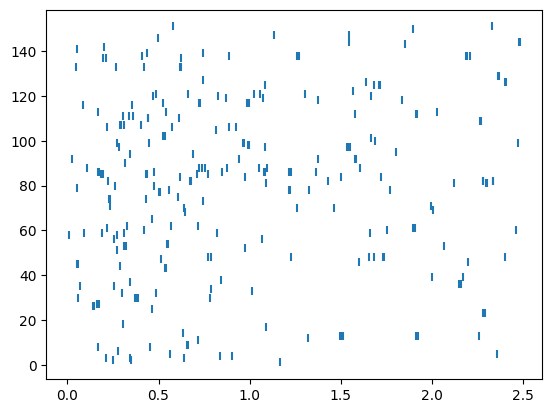

In [7]:
dd = spike_time_df[spike_time_df['spike_cell']==48]
plt.scatter(dd['spike_time'], dd['spike_trial'], marker='|')

Make a scatter plot of response times versus spike trials, for cell number 48.

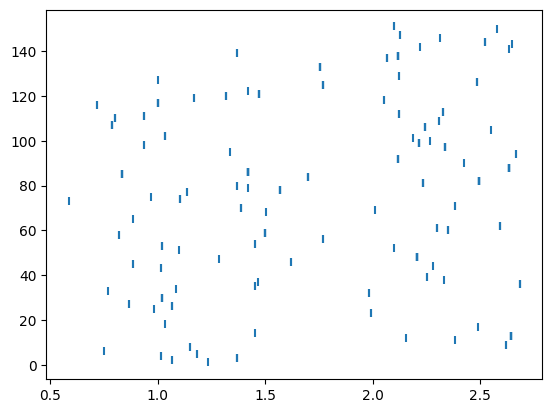

In [8]:
dd = spike_time_df[spike_time_df['spike_cell']==48]
plt.scatter(dd['response_time'], dd['spike_trial'], marker='|')

Create single plot containing both:
- spike time versus spike trials
- response times versus spike trials

.. for cell number 48.

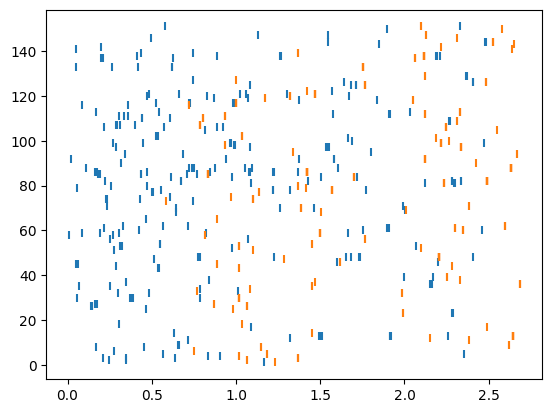

In [9]:
dd = spike_time_df[spike_time_df['spike_cell']==48]
plt.scatter(dd['spike_time'], dd['spike_trial'], marker='|')
plt.scatter(dd['response_time'], dd['spike_trial'], marker='|')

We can better assess the relation between the response event and neuron spiking by sorting the cells by response time.

**Example**: Sort the spike data for cell 48 by response time. Call the result `spike_cell_48_df`

In [10]:
spike_cell_48_df = spike_time_df[spike_time_df['spike_cell']==48]
spike_cell_48_df = spike_cell_48_df.sort_values(by="response_time")
spike_cell_48_df

,spike_id,spike_time,spike_cell,spike_trial,response_time,feedback_time,gocue,active_trials
58033,99338,0.742227,48,73,0.585404,0.620010,0.500808,True
58137,99442,0.356179,48,116,0.718770,0.752412,0.623610,True
58136,99441,0.087679,48,116,0.718770,0.752412,0.623610,True
57941,99246,0.278203,48,6,0.750819,0.786012,0.618810,True
57973,99278,1.013364,48,33,0.767115,0.805213,0.672411,True
...,...,...,...,...,...,...,...,...
58094,99399,0.686661,48,94,2.667009,2.702443,1.155618,True
58093,99398,0.342161,48,94,2.667009,2.702443,1.155618,True
57979,99284,2.161123,48,36,2.683245,2.684843,1.171619,True
57978,99283,2.155156,48,36,2.683245,2.684843,1.171619,True


Add a new column called `spike_trial_sorted` to `spike_cell_48_df` that is the `spike_trial` data reset to 0. **Hint** use `df.factorize()`

In [11]:
spike_cell_48_df ["spike_trial_sorted"] = spike_cell_48_df ['spike_trial'].factorize()[0]
spike_cell_48_df 

,spike_id,spike_time,spike_cell,spike_trial,response_time,feedback_time,gocue,active_trials,spike_trial_sorted
58033,99338,0.742227,48,73,0.585404,0.620010,0.500808,True,0
58137,99442,0.356179,48,116,0.718770,0.752412,0.623610,True,1
58136,99441,0.087679,48,116,0.718770,0.752412,0.623610,True,1
57941,99246,0.278203,48,6,0.750819,0.786012,0.618810,True,2
57973,99278,1.013364,48,33,0.767115,0.805213,0.672411,True,3
...,...,...,...,...,...,...,...,...,...
58094,99399,0.686661,48,94,2.667009,2.702443,1.155618,True,100
58093,99398,0.342161,48,94,2.667009,2.702443,1.155618,True,100
57979,99284,2.161123,48,36,2.683245,2.684843,1.171619,True,101
57978,99283,2.155156,48,36,2.683245,2.684843,1.171619,True,101


Make a single plot containing both: 
- scatter plot of `spike_trial_sorted` (y-axis) versus the `spike_time` (x-axis).
- scatter plot of `spike_trial_sorted` (y-axis) versus the `response_time` (x-axis).

.. for cell 48.

Text(0.5, 0, 'time/s')

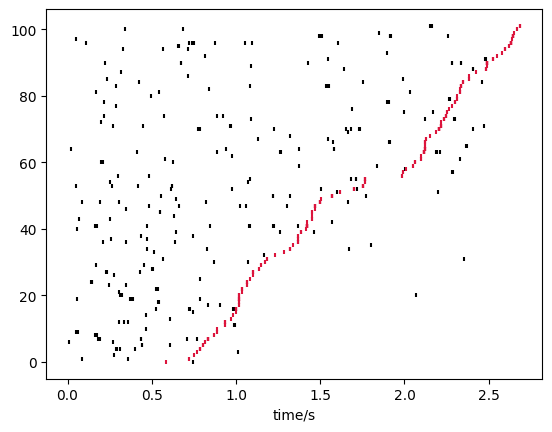

In [12]:

plt.scatter(spike_cell_48_df['spike_time'], spike_cell_48_df['spike_trial_sorted'], marker="|", s=10, c="k");
plt.scatter(spike_cell_48_df['response_time'], spike_cell_48_df['spike_trial_sorted'], marker="|", s=10, c="crimson");
plt.xlabel('time/s')


Cell 48 clearly has a strong relationship to the subject's response. Can you think of why this may be? What brain region is cell 48 in?

**Hint** - use `dataset["brain_groups"].to_dataframe().reset_index()`

In [13]:
dd=  dset["brain_groups"].to_dataframe().reset_index()
dd[dd['cell']==48]

,cell,brain_groups
47,48,visual cortex


Let's combine sorting and scatter plots to investigate whether there are any patterns in the spike timing of cell 187? 

Here are the steps:
- extract the dataframe entries for cell 187
- sort the new dataframe by `"response_time"`
- created a new column called `spike_trial_sorted` that is the reset version of spike trial starting from 0
- plot the scatter plot showing `spike_time` and `response_time` across `spike_trials_sorted`. 

Text(0.5, 0, 'time/s')

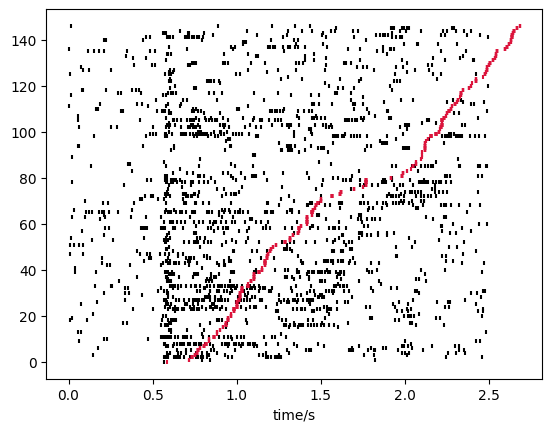

In [14]:
dd = spike_time_df[spike_time_df['spike_cell']==187]
dd = dd.sort_values(by="response_time")

dd["spike_trial_sorted"] = dd['spike_trial'].factorize()[0]

plt.scatter(dd['spike_time'], dd['spike_trial_sorted'], marker="|", s=10, c="k");
plt.scatter(dd['response_time'], dd['spike_trial_sorted'], marker="|", s=10, c="crimson");
plt.xlabel('time/s')


What do you notice about the above rasterplot? Do you think that anything special happens around 0.5s into each trial? **Hint** Look at the Attributes of the `dataset`

---

## Spiking activity in different brain areas

The steinmetz dataset also includes information about which brain region each neuron belongs to. In this section we will use pandas and matplotlib to find the most active brain areas and visualize the spiking activity for each brain area.

Create a dataframe that contains the brain area and call it `brain_region_df`.


| Command                                               | Description                                                                                     |
|-------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| `pd.merge(df_1, df_2)`                                | Merge `df_1` and `df_2` DataFrames based on common columns.                                     |
| `pd.merge(df_1, df_2, left_on='column_on_df_1', right_on='column_on_df_2')`                                | Merge `df_1` and `df_2` DataFrames based on `column_on_df_1` on `df_1` and `column_on_df_2` on `df_2`.                                     |
| `df.rename(columns={"old_column_name": "new_column_name"})` | Rename the "old_column_name" column to "new_column_name" in the DataFrame.                      |
| `df.sort_values(by="column_b")`                       | Sort the DataFrame based on the values in the "column_b" column in ascending order.             |
| `df['column_a'].factorize()[0]`                       | Encode the "column_a" column as an enumerated type, replacing each unique value with an integer. `[0]` returns just the array of integers. |
|`df['col_A'].value_counts()`|counts and lists how many times each unique category appears in the `col_A`|


Create a single DataFrame with information about spikes and brain areas.

In [15]:
spike_cols = ['spike_time', 'spike_cell', 'spike_trial']
df = dset[spike_cols].to_dataframe().reset_index()

brain_region_df = dset["brain_area"].to_dataframe().reset_index()

spike_region_df = pd.merge(df, brain_region_df, left_on='spike_cell', right_on='cell')
spike_region_df

,spike_id,spike_time,spike_cell,spike_trial,cell,brain_area
0,1,2.362881,1,1,1,PO
1,2,2.384915,1,1,1,PO
2,3,1.450718,1,2,1,PO
3,4,1.459585,1,2,1,PO
4,5,1.963452,1,2,1,PO
...,...,...,...,...,...,...
1836004,1836005,2.240762,1268,205,1268,root
1836005,1836006,2.268195,1268,205,1268,root
1836006,1836007,2.401162,1268,205,1268,root
1836007,1836008,1.650607,1268,213,1268,root


**Example**: What brain areas were recorded from this specific mouse?

In [16]:
spike_region_df.brain_area.unique()

array(['PO', 'VISam', 'LP', 'DG', 'CA1', 'root'], dtype=object)

How many spikes occured in  each brain area?

In [17]:
spike_region_df['brain_area'].value_counts()

brain_area
root     572279
PO       445466
VISam    313577
LP       301621
DG       124526
CA1       78540
Name: count, dtype: int64

**Example**: Let's focus on the spikes for trial 187 and sort the dataframe by brain area.

In [30]:
dd = spike_region_df[spike_region_df["spike_trial"] == 187]
dd = dd.sort_values(by="brain_area")
dd["ordered_index"] = dd.spike_cell.factorize()[0]
dd

,spike_id,spike_time,spike_cell,spike_trial,cell,brain_area,ordered_index
818501,818502,1.757417,470,187,470,CA1,0
273926,273927,0.079684,145,187,145,CA1,1
810864,810865,2.353217,465,187,465,CA1,2
810863,810864,2.342650,465,187,465,CA1,2
810862,810863,1.872784,465,187,465,CA1,2
...,...,...,...,...,...,...,...
1471034,1471035,1.581396,868,187,868,root,922
1472233,1472234,0.688164,869,187,869,root,920
1472234,1472235,1.073696,869,187,869,root,920
1426025,1426026,0.170764,828,187,828,root,824


Which brain areas do the cells that spiked in trial 187 belong to?

In [32]:
dd = spike_region_df[spike_region_df["spike_trial"] == 187]
dd = dd.sort_values(by="brain_area")
dd["ordered_index"] = dd.spike_cell.factorize()[0]

Make a scatterplot for brain area `"CA1"` showing the `spike_time` on the x axis and `ordered_index` on the y axis.

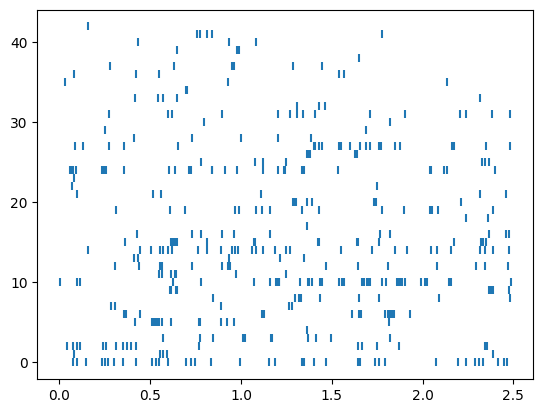

In [35]:
area = "CA1"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area['spike_time'], dd_area['ordered_index'],  marker='|', label=area)

Make a scatterplot for brain area `"VISam"` showing the `spike_time` on the x axis and `ordered_index` on the y axis.

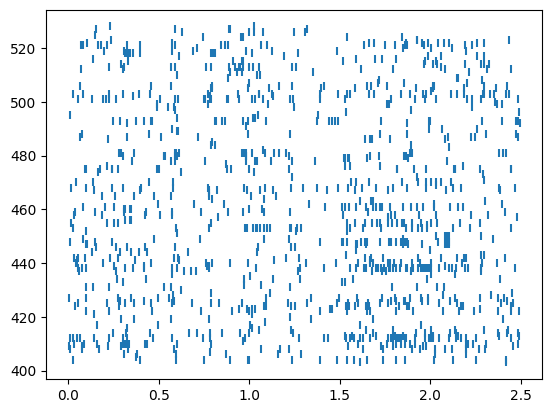

In [36]:
area = "VISam"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area['spike_time'], dd_area['ordered_index'],  marker='|', label=area)

**Example**: Create a single figure containing the spiking activity of both "CA1" and "DG" brain areas, for trial 187.

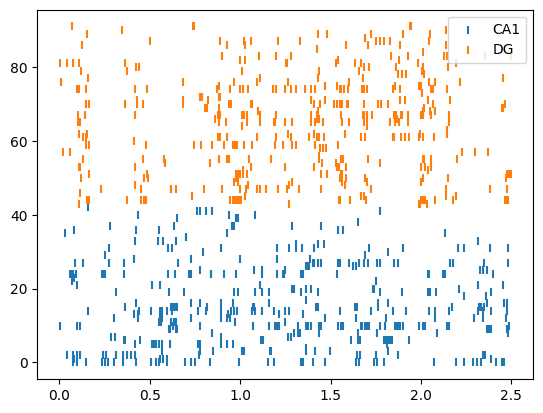

In [37]:
dd = spike_region_df[spike_region_df["spike_trial"] == 187]
dd = dd.sort_values(by="brain_area")
dd["ordered_index"] = dd.spike_cell.factorize()[0]

area = "CA1"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area.spike_time, dd_area.ordered_index,  marker='|', label=area)

area = "DG"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area.spike_time, dd_area.ordered_index, marker='|', label=area)

plt.legend()

Create a single figure containing the spiking activity of both "CA1" and "DG" and "LP" brain areas, for trial 187.

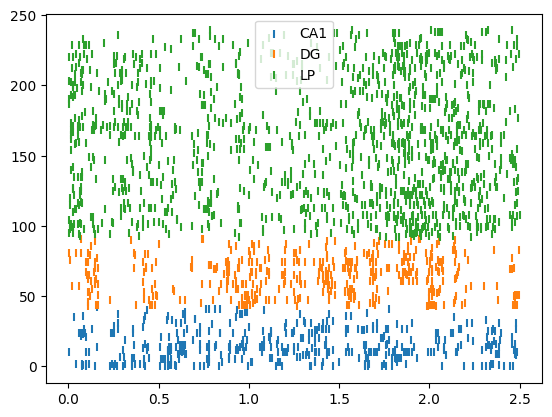

In [38]:
dd = spike_region_df[spike_region_df["spike_trial"] == 187]
dd = dd.sort_values(by="brain_area")
dd["ordered_index"] = dd.spike_cell.factorize()[0]

area = "CA1"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area.spike_time, dd_area.ordered_index,  marker='|', label=area)

area = "DG"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area.spike_time, dd_area.ordered_index, marker='|', label=area)

area = "LP"
dd_area = dd[dd["brain_area"] == area]
plt.scatter(dd_area.spike_time, dd_area.ordered_index, marker='|', label=area)

plt.legend()